<a href="https://colab.research.google.com/github/thalitadru/ml-class-epf/blob/main/TutorialNNwithKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Sequential APIs of PyTorch and Keras

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

# In this notebook we'll use torch as the backend for keras
# comment the line bellow and restart the kernel if you want to use tensorflow.
os.environ["KERAS_BACKEND"] = "torch"

import keras_core as keras

Both `keras` and `torch.nn` offer you a high level API to implement neural networks easily.
Most models can be represented using the `keras.Sequential`/`torch.nn.Sequential` API.
For more complex models, we can use `keras.functional`/`torch.nn.functional` and/or sub-class `keras.Model`/`torch.nn.Module`.

`keras` however has the advantage of providing built-in methods to train, predict and evaluate. On `torch.nn` it is necessary to write your own training and evaluation loops.

This tutorial demonstrates the `Sequential` API for both libraries, by reimplementing the network you coded during our last lab session.

Here is a diagram of network:

<img alt="NN diagram with 784 inputs, followed by 3 layers with 128, 64 and 10 nodes, respectively" src="https://raw.githubusercontent.com/lionelmessi6410/Neural-Networks-from-Scratch/0145471d6124831c071b3a772c943b9a57128984//figs/deep_nn-1.png" width="500"></img>


## Loading the dataset

This time we'll use keras to load the MNIST dataset:

In [69]:
# Load the data and split it between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

Note that here the image pixels are not flatenned: we have 28x28 arrays. Also pay attention to the data type: we have pixel values in `uint8` (i.e., from 0 to 255).

In [70]:
display(type(X_train), X_train.shape, X_train.dtype)
display(type(y_train), y_train.shape, y_train.dtype)

numpy.ndarray

(60000, 28, 28)

dtype('uint8')

numpy.ndarray

(60000,)

dtype('uint8')

Before we proceed, we will:
- flatten the images to 28*28 sized vectors (using `reshape`)
- normalize pixel values to range $[0,1]$ (by casting them to `float32` then dividing by 255)

In [35]:
#TODO YOUR CODE HERE


## Implementation with [`torch.nn`](https://pytorch.org/docs/stable/nn.html)

- [`torch.nn`](https://pytorch.org/docs/stable/nn.html) contains many useful utilities for neural netwoks and ML models in general
- many commonly used layers and loss functions are readily available

### Description
We can use the layers already coded in [`torch.nn`](https://pytorch.org/docs/stable/nn.html) to express our network. 

In [8]:
from torch import nn

We are going instantiate the layers, one after the other, to represent 

In [ ]:
#TODO On each layer, write the number of neurons it contains
model = nn.Sequential(
    nn.LazyLinear(),
    nn.ReLU(),
    nn.LazyLinear(),
    nn.ReLU(),
    nn.LazyLinear()
    # we wont apply softmax in the architecture, it will be done when we compute the loss function
)

The fully-connected layers we implemented in the last lab can be created using `nn.Linear` or `nn.LazyLinear`:
- with `nn.Linear` you need to specify the dimensions of the input and the output (so that it knows the shape for the weight matrix and bias vector)
- with `nn.LazyLinear` you only need to state the number of neurons in that particular layer. When you first call the network on some data, the appropriate shape will be automatically inferred.

Note the activation functions must be listed as separate layers.

If we display the model, we get a summary of its layers. Note how part of the shapes appear to be zero. This is because we have not ye given any data to the network.

In [12]:
display(model)

Sequential(
  (0): LazyLinear(in_features=0, out_features=128, bias=True)
  (1): ReLU()
  (2): LazyLinear(in_features=0, out_features=64, bias=True)
  (3): ReLU()
  (4): LazyLinear(in_features=0, out_features=10, bias=True)
)

Let's process some data with the forward pass, so that we can infer the proper shapes for the parameters. To do that, we call the model giving (a portion) ouf our dataset as argument:


In [13]:
model(torch.from_numpy(X_train)[0:3])

tensor([[-0.1046,  0.0662, -0.0647, -0.0259,  0.0337,  0.0061, -0.0082, -0.0810,
         -0.0025, -0.1022],
        [-0.1274,  0.0425, -0.0552, -0.0180,  0.0164,  0.0393, -0.0033, -0.1047,
          0.0055, -0.0899],
        [-0.1049,  0.0563, -0.0672,  0.0172,  0.0494,  0.0146,  0.0154, -0.1149,
         -0.0242, -0.0939]], grad_fn=<AddmmBackward0>)


_Note that we need to convert the numpy array to a torch tensor first, using `torch.from_numpy`._

Now if we display the model summary again, we will see all the shapes defined:

In [14]:
display(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

### Loss function

Besides layers, `torch.nn` also has many loss functions. 

In [15]:
print('Avaliable losses in torch.nn')
[n for n in dir(torch.nn) if not n.startswith('_') and n.find('Loss')>-1]

Avaliable losses in torch.nn


['AdaptiveLogSoftmaxWithLoss',
 'BCELoss',
 'BCEWithLogitsLoss',
 'CTCLoss',
 'CosineEmbeddingLoss',
 'CrossEntropyLoss',
 'GaussianNLLLoss',
 'HingeEmbeddingLoss',
 'HuberLoss',
 'KLDivLoss',
 'L1Loss',
 'MSELoss',
 'MarginRankingLoss',
 'MultiLabelMarginLoss',
 'MultiLabelSoftMarginLoss',
 'MultiMarginLoss',
 'NLLLoss',
 'NLLLoss2d',
 'PoissonNLLLoss',
 'SmoothL1Loss',
 'SoftMarginLoss',
 'TripletMarginLoss',
 'TripletMarginWithDistanceLoss']

Since we have a classification problem, we'll use the cross-entropy loss. In [`torch.nn`](https://pytorch.org/docs/stable/nn.html), this loss expects to receive the networks outpus before softmax. These outputs are called **logits**. This is why we did not include a softmax activation at the end of the model we just described.

In [16]:
# Chech the documentation for the function and note that it states expecing logits as input
# ?torch.nn.CrossEntropyLoss

We can instantiate a loss function as follows:

In [17]:
loss_fn = torch.nn.CrossEntropyLoss()

We can then apply the loss to a pair of input `torch.Tensor`s:

In [ ]:
#TODO complete the code bellow
# Demonstration of loss fn on synthetic data
# 1) generate 5 fake predictions (i.e. a 5x10 array with random values)
fake_pred_logits = torch.from_numpy(...)
# 2) pick 5 labels from the training set (i.e. the first 5 rows of y_train)
fake_true_labels = torch.from_numpy(...)

# 3) Calculate the loss
loss_fn(fake_pred_logits, fake_true_labels)

### Optimizer

We have many iterative gradient-based optimization algorithms implemented in the module `torch.optim`:


In [19]:
[n for n in dir(torch.optim) if not n.startswith('_')]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 'lr_scheduler',
 'swa_utils']

We are going to use SGD with momentum for this example:

In [20]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Training 

Now we need to write a training loop, the same way we had to do in the last lab.

In [23]:
N_EPOCHS = 2

BATCH_SIZE = bs = 5


running_loss = 0
for epoch in range(N_EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Tell torch we want to use the model in train mode
    model.train(True)  # this whay it knows it must keep track of gradients

    # Now let's iterate through the data to adjust the network parameters
    for i, batch_idx in enumerate(range(0, X_train.shape[0], bs)):
        # Separate batch
        X_train_batch = X_train[batch_idx:batch_idx+bs,...]
        y_true_batch = y_train[batch_idx:batch_idx+bs]

        # Convert numpy batches to torch tensor
        X_train_batch = torch.from_numpy(X_train_batch)
        y_true_batch = torch.from_numpy(y_true_batch)



        # Now we start. First we compute the forward pass
        pred_logits = model(X_train_batch)

        # Then we compute the loss
        # XXX Atention to the order of the arguments
        # first y_pred, then y_true
        loss = loss_fn(pred_logits, y_true_batch)

        # To compute the backward pass, all we need to do is
        loss.backward()  # This will compute the gradients of the loss function

        # To apply the computed gradients as an optimization step
        # thus updating the network's weights and biases, we just do
        optimizer.step()

        # In torch new gradients always get accumulated to the current value within the grad variables.
        # We need to zero gradient variables between each call to `backward`
        optimizer.zero_grad()  # if we dont reset the grad variables, we would be summing gradients of this iteration on top of those of the previous one.

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.


EPOCH 1:
  batch 1000 loss: 1.753686069190502
  batch 2000 loss: 0.598740672133863
  batch 3000 loss: 0.4397623418169096
  batch 4000 loss: 0.40081194310169665
  batch 5000 loss: 0.346750245091971
  batch 6000 loss: 0.33392595157586036
  batch 7000 loss: 0.2902937762066722
  batch 8000 loss: 0.28731116868671963
  batch 9000 loss: 0.2810087467390113
EPOCH 2:
  batch 1000 loss: 0.391277783308411
  batch 2000 loss: 0.22629813047288916
  batch 3000 loss: 0.20920873675961046
  batch 4000 loss: 0.21710758922970855
  batch 5000 loss: 0.19431770092237274
  batch 6000 loss: 0.1891136191827245
  batch 7000 loss: 0.17206865526689216
  batch 8000 loss: 0.16911742506804875
  batch 9000 loss: 0.1753131607613759


### Evaluation
To use the model for inference only (without saving intermediate activations for backpropagation) we tell torch we are changing into `eval()` mode:

In [31]:
model.eval()
logits_test = model(torch.from_numpy(X_test))
logits_test[0]

tensor([ -0.3067,  -3.1290,   6.4420,   6.2331,  -6.1542,  -1.7733, -12.4464,
         12.1067,   0.6426,   1.7244], grad_fn=<SelectBackward0>)

Remember the network gives us the logits. To get probabilites, we need to apply softmax to the logits:

In [32]:
probas_test = torch.nn.functional.softmax(logits_test, dim=1)
probas_test[0,:]

tensor([4.0382e-06, 2.4015e-07, 3.4445e-03, 2.7952e-03, 1.1659e-08, 9.3165e-07,
        2.1577e-11, 9.9371e-01, 1.0434e-05, 3.0781e-05],
       grad_fn=<SliceBackward0>)

To get the predicted class id, we need to apply `argmax` (to either the logits or the porbabilites, we'll get the same results anyway):

In [33]:
y_pred_test = np.argmax(logits_test.detach().numpy(), axis=1)
y_pred_test[0]

7

From these predictions, we can compute evaluation metrics as usual:

In [29]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred_test)

0.9512

## Implementation with `keras`


### Description
Describing a model with keras will be very similar to [`torch.nn`](https://pytorch.org/docs/stable/nn.html). Here is the equivalent model in keras:

In [72]:

model_k = keras.Sequential([
    # We let keras know the expected input shape
    keras.layers.Input(shape=(28*28,), name='Input'),
    # Then we go on instantiating the layers
    keras.layers.Dense(128, activation='relu', name='dense1'),
    keras.layers.Dense(64, activation='relu', name='dense2'),
    keras.layers.Dense(10, name='logits')
    # we wont apply softmax in the architecture, it will be done when we compute the loss function
])

We can find many layers implemented in `keras.layers`. Note that here our usual fully-conneted layer is called a `Dense` layer here. 
Another difference: you can specify activation functions when instantiating the `Dense` layer. No need to 

Note we can also create the same network  using `model.add`:

```python
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(28*28,)))
model.add(keras.layers.Dense(128, activation='relu', name='dense1'))
...
# and so on
```

#### Printing the model summary
The model’s summary() method displays all the model’s layers, including each layer’s
name (which is automatically generated unless you set it when creating the layer), its output shape (None means the batch size can be anything), and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters. Here we only have trainable parameters (we will see examples of non-trainable parameters later when doing some transfer learning):

In [73]:
model_k.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense1 (Dense)                  │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense2 (Dense)                  │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ logits (Dense)                  │ (None, 10)                │        650 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

You can use the utility function [`keras.utils.plot_model`](https://keras.io/keras_core/api/utils/model_plotting_utils/#plot_model-function) to visualize a graph of the network you just created:

_(This function has external dependencies. Follow the warning message to install the necessary software.)_

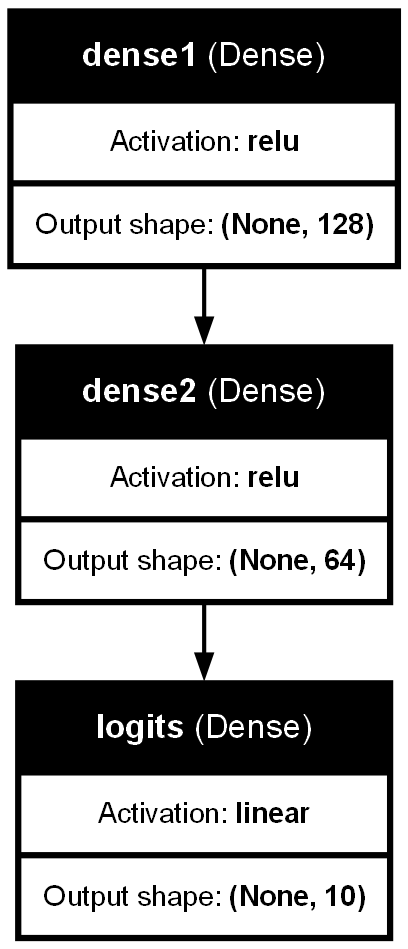

In [74]:
keras.utils.plot_model(model_k, "my_mnist_model.png",
                        show_shapes=True,
                        show_layer_names=True,
                        show_layer_activations=True,
                        dpi=150)

#### Layers and weights
 `model.layers` will contain a list of `keras.layers` at the end:

In [75]:
model_k.layers

[<Dense name=dense1, built=True>,
 <Dense name=dense2, built=True>,
 <Dense name=logits, built=True>]

Each layer has a name. You can attribute one during its creation. If you don't, a standard one will be created for you:

In [76]:
for layer in model_k.layers:
    print(layer.name)

dense1
dense2
logits


You can access your model's layers by indexing `model.layers` or by their name (using `model.get_layer`)

In [77]:
hidden1 = model_k.layers[1]
hidden1.name

'dense2'

In [78]:
model_k.get_layer(hidden1.name) is hidden1

True

All the parameters of a layer can be accessed using its get_weights() and set_weights() methods. For a Dense layer, this includes both the connection weights and the bias terms:

In [79]:
weights, biases = hidden1.get_weights()

We can save this initial weights for later using `model.save_weights`, in case we want to reset our model to its initial state:

In [80]:
model_k.save_weights('init.weights.h5')

`h5` is the extension corresponding to the default keras format, HDF5. To load back the weights, just call 
```python 
model.load_weights('init.weights.h5')
```


#### TODO: Check weights and biases values and shape

In [81]:
# TODO your code here


Notice that the Dense layer initialized the connection weights randomly, and the biases were initialized to zeros, which is fine. If you ever want to use a different initialization method, you can set `kernel_initializer` (kernel is another name for the matrix of connection weights) or `bias_initializer` when creating the layer. We will discuss initializers later, but if you want the full list, see https://keras.io/initializers/.

### Loss function
Many [loss functions](https://keras.io/keras_core/api/losses/) are implemented in keras. We have multiple variants of the cross-entropy loss (check the section ["Probabilistc losses"](https://keras.io/keras_core/api/losses/probabilistic_losses/) in the documentation).

Here we need to choose categorical cross entropy, since our problem is multi-class.
Additionally, we need to use the `sparse` version of the categorical cross entropy because our labels are not one-hot encoded:

In [83]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

If they were already encoded, we would use `CategoricalCrossentropy` directly.

Moreover, in keras the default is for the losses to take in probabilities. So if our model outputs logits, we must set `from_logits=True` when instantiating he loss function:

In [84]:
loss_fn_k = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

We can also apply it to any pair of input tensors, like we did in PyTorch. **The order of the arguments is reversed**: first true labels then the predicted logits:

In [85]:
loss_fn_k(fake_true_labels, fake_pred_logits)

tensor(2.4662)

### Optimizer
Just like with `torch.nn`, many optimizers are implemented in [`keras.optimizers`](https://keras.io/keras_core/api/optimizers/).
To instantiate the same optimizer as we did in PyTorch, we can do:

In [86]:
optimizer_k = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### Training

This is main point where keras makes things much simpler. We do not need to mannualy write training and evaluation loops: there are built-in `fit` and `evaluate` methods ready to be used, like in `sklearn`.

#### **Attention: `compile` before you `fit`**

In keras, before we start training, we need to let it know: 
- the [loss function](https://keras.io/keras_core/api/losses/) we want to optimize
- the [optimization](https://keras.io/keras_core/api/optimizers/) method we want to use
- any [metrics](https://keras.io/keras_core/api/metrics/) we want logged during training and evaluation [optional].

This is done calling the `compile()` method on the model object:

In [87]:
model_k.compile(
    loss=loss_fn_k,
    optimizer=optimizer_k,
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

If we need to change the learning rate after calling compile, we can. Just need to acess `model.optimizer.learning_rate`:

In [88]:
model_k.optimizer.learning_rate = 0.01

Note that it is also possible to chose loss, metrics and optimizer using string names, e.g. 
```python
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
```
However, when doing so, you are instantiating them with their default parameters.

#### Calling `fit()`
Now the model is ready to be trained. For this we simply need to call its `fit()` method.

As arguments, we provide the training samples and labels. We can also set some keyword arguments adjust the training procedure. Check documentation to see how to specify the batch size, for instance.


In [89]:
out = model_k.fit(X_train, y_train, epochs=3,
                  validation_split=0.2)

Epoch 1/3
  28/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2319 - loss: 2.2325

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8301 - loss: 0.5727 - val_accuracy: 0.9473 - val_loss: 0.1817
Epoch 2/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9571 - loss: 0.1391 - val_accuracy: 0.9644 - val_loss: 0.1178
Epoch 3/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9707 - loss: 0.0992 - val_accuracy: 0.9668 - val_loss: 0.1089


### Plotting learning curves
`model.fit` returns a history object that logs loss values for training and validation sets, as well as accuracy values (because we set it as a metric during the `compile` step).

In [90]:
out.params

{'verbose': 'auto', 'epochs': 3, 'steps': 1500}

In [91]:
out.epoch

[0, 1, 2]

In [92]:
out.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [93]:
def plot_learning_curves(out):
    df = pd.DataFrame(out.history, index=np.array(out.epoch)+1)
    df.plot(figsize=(8, 5), fontsize=12)
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel('epochs', fontsize=12)
    plt.title ('learning curves', fontsize=12)
    plt.legend(fontsize=12)
    plt.show()

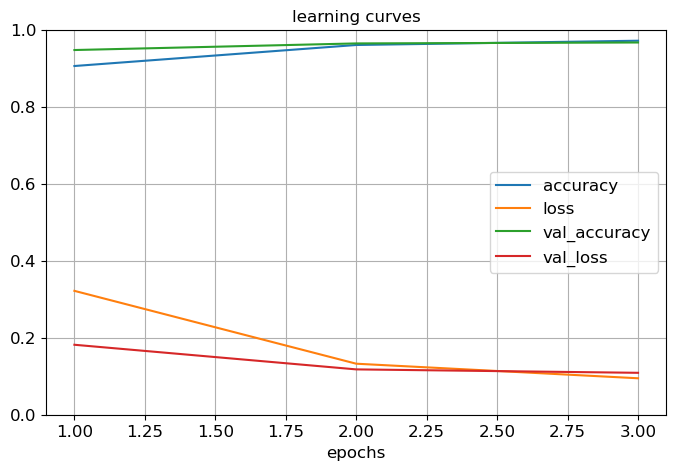

In [94]:
plot_learning_curves(out)

## Evaluating and making predictions on the test set

You can use the methods `model.evaluate` and `model.predict` on the test set:

In [95]:
model_k.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9608 - loss: 0.1173


[0.10165989398956299, 0.9670000076293945]

In [96]:
logits_test = model_k.predict(X_test)

138/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Remember the network gives us the logits. To get probabilites, we need to apply softmax to the logits:

In [97]:
pred_proba_test = keras.activations.softmax(logits_test).numpy()
pred_proba_test

array([[6.0465773e-08, 1.4979694e-08, 2.4720328e-05, ..., 9.9974328e-01,
        5.8710748e-07, 5.8945511e-06],
       [2.9837352e-07, 2.6712037e-04, 9.9913895e-01, ..., 1.1086597e-06,
        2.2576005e-05, 3.1850897e-11],
       [2.7249407e-06, 9.8853135e-01, 2.2589606e-03, ..., 6.4986073e-03,
        1.9454348e-03, 8.8614952e-06],
       ...,
       [4.5135735e-11, 1.0411751e-10, 4.1748587e-11, ..., 1.7396631e-07,
        2.8468205e-06, 1.0920153e-05],
       [8.9152655e-07, 7.7643065e-08, 5.6184084e-09, ..., 2.1978524e-08,
        2.9923167e-04, 4.5705830e-09],
       [6.3655335e-08, 2.0048834e-09, 1.2800144e-06, ..., 4.0876982e-10,
        4.0246721e-07, 3.0082958e-10]], dtype=float32)

Let's see the predictions for the first 3 images:

In [98]:
pred_proba_test.round(2)[:3,:]

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ]],
      dtype=float32)

To get the predicted class id, we need to apply `argmax` (to either the logits or the porbabilites, we'll get the same results anyway):

In [99]:
y_pred_test = np.argmax(pred_proba_test, axis=-1)
y_pred_test[:3]

array([7, 2, 1], dtype=int64)